# Prep all data

In [1]:
import pandas as pd
import duckdb
connection = duckdb.connect(database=':memory:', read_only=False)

capacity_df = pd.read_parquet(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\trappe_ff\mix.parquet')
capacity_df = capacity_df.loc[:, ['p', 'temperature', 'adsorption_type', 'mol_uc_avg', 'component_num']]
capacity_df = capacity_df.astype({'p': int, 'temperature': int, 'component_num': int, 'mol_uc_avg': float,
                                  'adsorption_type': 'category'})

capacity_df['alken'] = capacity_df['component_num'].apply(lambda x: f'C{(x+1)*2}').astype(str) + \
                            capacity_df['adsorption_type'].apply(lambda x: '' if x == 'absolute' else '_out').astype(str)
print(capacity_df.shape)
s = """
with t1 as (
SELECT * FROM capacity_df where adsorption_type = 'absolute'),
t2 as (
SELECT * FROM capacity_df where adsorption_type = 'excess'),
t3 as (
select t2.*, t1.mol_uc_avg - t2.mol_uc_avg as capacity from t1 join t2 on t1.temperature = t2.temperature 
and t1.component_num = t2.component_num and t1.p = t2.p)

select *, mol_uc_avg as capacity from capacity_df where adsorption_type = 'absolute'
union
select t3.*from t3
order by temperature, p, component_num, adsorption_type
"""
capacity_df = connection.execute(s).fetchdf()
capacity_df.to_pickle('../files/processed_data/capacity_df.pkl')
capacity_df.query('temperature == 300 and p == 100000').head(2)

(1210, 6)


,p,temperature,adsorption_type,mol_uc_avg,component_num,alken,capacity
0,100000,300,absolute,1.554528,0,C2,1.554528
1,100000,300,excess,1.458681,0,C2_out,0.095847


In [2]:
distribution = pd.read_pickle(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\clusterization\distribution.pkl')\
    .drop(columns=['atom_name']).rename(columns={'T': 'temperature'})
distribution['alken'] = distribution['n'].apply(lambda x: f'C{x}').astype(str)
distribution = distribution[~distribution.file.str.contains('lowT')]
s = '''
with t1 as (
select * from distribution where cluster = 0),
t2 as (
    select d.*, d.N_mol / t1.N_mol as ratio from distribution as d
    left join t1 using(alken, p, temperature))

select * from t2 where cluster == 1
'''
distribution_df = connection.execute(s).fetchdf()
distribution_df.to_pickle('../files/processed_data/distribution_df.pkl')
distribution_df.head(2)

,file,cluster,N_mol,p,temperature,n,G,alken,ratio
0,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,174113,100000,300,2,-0.147839,C2,1.281458
1,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,3830784,100000,300,4,0.083982,C4,0.868594


c:\Users\lt0828\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


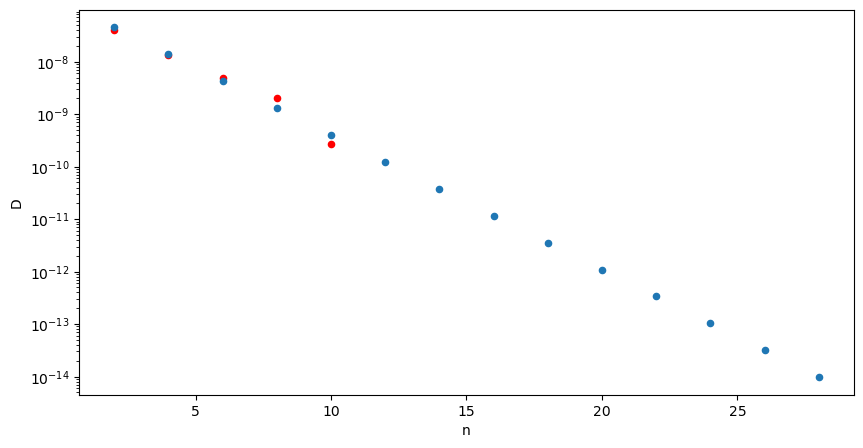

In [3]:
import numpy as np
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
diffusions = pd.DataFrame({'n': [2, 4, 6, 8, 10], 
                           'D': [4.010918e-08, 1.324638e-08, 4.875015e-09, 2.026042e-09, 2.767088e-10]})

diffusions['logd'] = diffusions['D'].apply(lambda x: np.log10(x))
diffusions.plot(x='n', y='D', kind='scatter', ax=ax, color='red')
model = LassoCV()
model.fit(diffusions[['n']], diffusions['logd'])

# Predict logD up to n = 28 and calculate D
n_pred = np.arange(2, 29, 2)
logd_pred = model.predict(n_pred.reshape(-1, 1))
D_pred = 10**logd_pred

# Create DataFrame for the prediction
diffusion_pred = pd.DataFrame({'n': n_pred, 'D': D_pred, 'logd_pred': logd_pred})
diffusion_pred.plot(x='n', y='D', kind='scatter', ax=ax)
plt.yscale('log')
diffusions = pd.concat([diffusions, diffusion_pred])
diffusions.to_pickle('../files/processed_data/diffusion.pkl')

c:\Users\lt0828\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


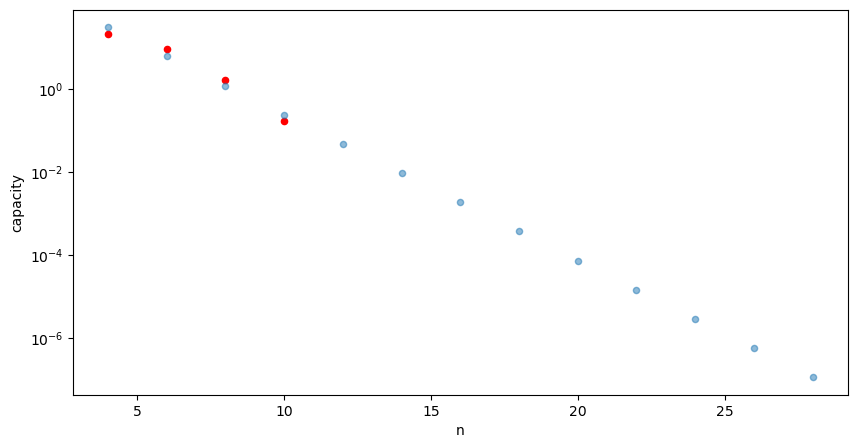

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = capacity_df.query('temperature == 300 and p == 100000 and adsorption_type == "absolute" and component_num > 0')\
    [['mol_uc_avg', 'component_num']]
df['n'] = df['component_num'].apply(lambda x: (x+1) * 2)
df['log_capacity'] = np.log10(df['mol_uc_avg'])
df.plot(x='n', y='mol_uc_avg', kind='scatter', ax=ax, color='red')
model = LassoCV(cv=4)
model.fit(df[['n']], df['log_capacity'])

# Predict logD up to n = 28 and calculate D
n_pred = np.arange(4, 29, 2)
log_capacity_pred = model.predict(n_pred.reshape(-1, 1))
capacity_pred = 10**log_capacity_pred
capacity_pred = pd.DataFrame({'n': n_pred, 'capacity': capacity_pred})
capacity_pred['adsorption_type'] = 'absolute'

capacity_pred.plot(x='n', y='capacity', kind='scatter', ax=ax, alpha=0.5)
plt.yscale('log')

In [5]:
capacity_pred = pd.concat([capacity_pred, pd.DataFrame({'n': n_pred, 'capacity': 17.817100, 'adsorption_type': 'excess'})], axis=0)
capacity_pred.loc[-1] = [2, 1.554528, 'absolute']
capacity_pred.loc[-2] = [2, 0.095847, 'excess']

capacity_pred['component_num'] = capacity_pred['n'].apply(lambda x: (x-2)/2)
capacity_pred['temperature'] = 300
capacity_pred['p'] = 100000
capacity_pred['mol_uc_avg'] = capacity_pred['capacity']

capacity_pred['alken'] = capacity_pred['component_num'].apply(lambda x: f'C{int(x+1)*2}').astype(str) + \
                            capacity_pred['adsorption_type'].apply(lambda x: '' if x == 'absolute' else '_out').astype(str) 
capacity_pred = capacity_pred.sort_values(by=['n', 'adsorption_type']).reset_index(drop=True)

capacity_pred = pd.concat([capacity_df.query('temperature == 300 and p == 100000'), 
                           capacity_pred.query('n>10')])

capacity_pred.to_pickle('../files/processed_data/capacity_pred.pkl')
capacity_pred.head(2)

,p,temperature,adsorption_type,mol_uc_avg,component_num,alken,capacity,n
0,100000,300,absolute,1.554528,0.0,C2,1.554528,NaN
1,100000,300,excess,1.458681,0.0,C2_out,0.095847,NaN


### Profile

In [6]:
import joblib
def read_file(file):
    df = pd.read_csv(file, sep='\s+', skiprows=1, header=None)
    df.columns = ['E', 'type', 'state']
    return df

def energy_diff(init_state, final_state, df):
    E = df.query(f'state == "{init_state}"')['E'].values
    if len(E) != 1:
        raise ValueError(f'{init_state} not found in the dataframe or there is more than one entry')
    init_state_energy = E[0]
    E = df.query(f'state == "{final_state}"')['E'].values
    if len(E) != 1:
        raise ValueError(f'{final_state} not found in the dataframe or there is more than one entry')
    final_state_energy = E[0]
    return final_state_energy - init_state_energy

def make_energies(df):
    energies = {'c2_adsorption': energy_diff('4', '5', df),
    'c2_desorbtion': energy_diff('5', '4', df),
    'c2_attaching': energy_diff('0', '1', df),
    'c2_deattaching': energy_diff('1', '0', df),
    'c2_insertion': energy_diff('1', '1,2', df),
    'c2_deinsertion': energy_diff('2', '1,2', df),
    'c4_deattaching': energy_diff('2', '2,3', df),
    'c4_attaching': energy_diff('3', '2,3', df),
    'c4_adsorption': energy_diff('4', '3', df),
    'c4_desorbtion': energy_diff('3', '4', df)}
    return energies

file = r'../files\raw_data\EtDimer_data\Cr3_PBED3BJ_fm_G_Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/CrIII_energies.pkl')
df.to_pickle('../files/processed_data/CrIII.pkl')

file = r'../files\raw_data\EtDimer_data\Cr2_PBED3BJ_fm_G_Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/CrII_energies.pkl')
df.to_pickle('../files/processed_data/CrII.pkl')

file = r'../files\raw_data\EtDimer_data\Ni_PBED3BJ_fm_G-Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/Ni_energies.pkl')
df.to_pickle('../files/processed_data/Ni.pkl')

# Reaction

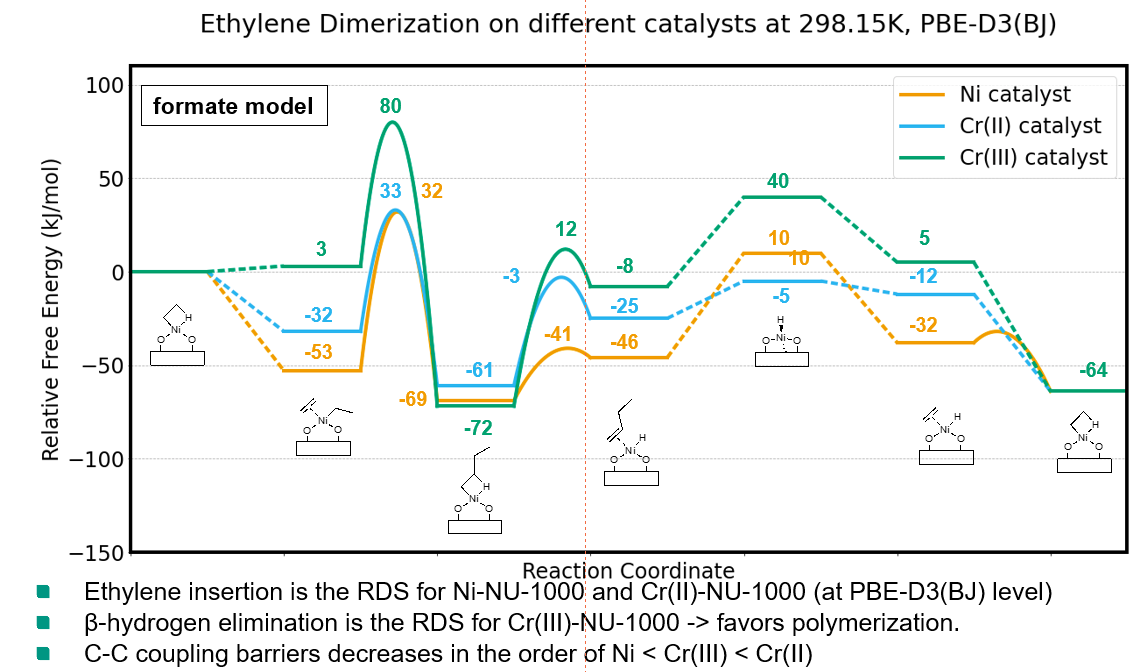

## Make reaction list

In [1]:
import sys
import os
import pandas as pd
import re
import seaborn as sns

sys.path.insert(0, os.path.abspath('../src'))
from diffusion import Reaction_Diffusion
from reaction_list_creator import *
from some_functions import *

diffusion_pred = pd.read_pickle('../files/processed_data/diffusion_pred.pkl')
capacity_pred = pd.read_pickle('../files/processed_data/capacity_pred.pkl')

L = 20 #nm
n = L/3
diffusion_pred['flux'] = diffusion_pred['D'] / (L * 1e-9)
diffusion_dict = diffusion_pred.set_index('n')['flux'].to_dict()

crII = joblib.load('../files/processed_data/CrII_energies.pkl')
ni = joblib.load('../files/processed_data/Ni_energies.pkl')
crIII = joblib.load('../files/processed_data/CrIII_energies.pkl')

In [2]:
capacity = pd.read_pickle('../files/processed_data/capacity_pred.pkl').query(f'temperature == 300 and p == 100000').set_index('alken')['capacity'].to_dict()

def make_reaction_list(n, k, k_ads=None, borders=(1e-7, 1e7)):
    k = k.copy()

    constants = make_known_constants(k)
    if k_ads is not None:
        constants['k_adsorption'] = k_ads
    
    for key, val in constants.items():
        constants[key] = val if val < borders[1] else borders[1]

    for key, val in constants.items():
        constants[key] = val if val > borders[0] else borders[0]

    constants = add_diffusion(constants, diffusion_dict)
    
    reaction_list = []
    for i in range(2, n+2, 2):
        reaction_list += make_reactions(i, **constants)
    
    return reaction_list[:-2]

make_reaction_list(4, crII, 666)

[['CatC2 <-> Cat + C2', 10000000.0, 10000000.0],
 ['CatC2 + C2 <-> CatC4', 30.04933181801927, 0.0002681043852819169],
 ['C2 <D> C2_out', 2.2799124864955975, 2.2799124864955975],
 ['CatC4 <-> Cat + C4', 497.37861198968244, 666]]

In [3]:
make_reaction_list(4, ni, 666)

[['CatC2 <-> Cat + C2', 33731.56033636709, 10000000.0],
 ['CatC2 + C2 <-> CatC4', 0.012677749161752789, 2.276702404700201e-05],
 ['C2 <D> C2_out', 2.2799124864955975, 2.2799124864955975],
 ['CatC4 <-> Cat + C4', 1432.9258682677923, 666]]

   1.000 conversion
   0.798 selectivity


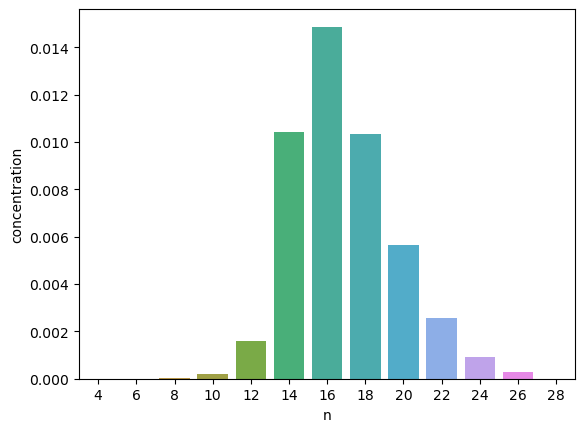

In [12]:
reaction_list = make_reaction_list(28, crII, 3e6, borders=(1e-7, 1e8))
r = Reaction_Diffusion(reaction_list, capacity=capacity)
hours = 1
start_time = 0
end_time = 60 * 60 * 1
n_steps = int(1e5)

c2_conc = 0.4
result = r.solve({'Cat': 1e-2, 'C2': c2_conc}, np.linspace(start_time, end_time, n_steps))

pat = re.compile(r'\bC(\d+)')
columns = list(filter(lambda x: pat.match(x), result.columns.values))

df = result[columns].iloc[n_steps-1000:]
df = df.mean()
df = df.reset_index(name='concentration')
df['n'] = df['index'].str.extract(r'(\d+)')[0].astype(int)
df = df.groupby('n').sum(numeric_only=True)

sns.barplot(x='n', y='concentration', data=df.query('n>2').reset_index())

light, heavy = df.query('8 <= n <= 18').sum(numeric_only=True).values[0], df.query('20 <= n <= 28').sum(numeric_only=True).values[0]

print('{:8.3f} conversion'.format(1 - df.query('n==2').sum().values[0]/c2_conc))
print('{:8.3f} selectivity'.format(light/(light+heavy)))
dft = df.loc[4:].reset_index()

In [24]:
def func(orientation, deorientation):
    reaction_list = make_reaction(29, crII, orientation, deorientation)#1e-5, 5e3
    r = Reaction_Diffusion(reaction_list, capacity=capacity)
    start_time = 0
    end_time = 60 * 60 * 1
    n_steps = int(1e5)

    c2_conc = 0.4
    result = r.solve({'Cat': 4, 'C2': c2_conc}, np.linspace(start_time, end_time, n_steps))

    pat = re.compile(r'\bC(\d+)')
    columns = list(filter(lambda x: pat.match(x), result.columns.values))

    df = result[columns].iloc[n_steps-1000:]
    df = df.mean()
    df = df.reset_index(name='concentration')
    df['n'] = df['index'].str.extract(r'(\d+)')[0].astype(int)
    df = df.groupby('n').sum(numeric_only=True)

    light, heavy = df.query('8 <= n <= 18').sum().values[0], df.query('20 <= n <= 28').sum().values[0]
    conversion = 1 - df.query('n==2').sum().values[0]/c2_conc
    selectivity = light/(light+heavy)
    return conversion, selectivity

def func2opt(x):
    conversion, selectivity = func(x[0], x[1])
    error = (0.2 - conversion)**2 + (0.79 - selectivity)**2
    return error

from scipy.optimize import minimize

initial_guess = [1e-06, 4.85e+04]
print("Initial guess:", func2opt(initial_guess))
# Define the bounds for each parameter
bounds = [(1e-6, 1e4), (1e-5, 1e5)]

# Perform the minimization
result = minimize(func2opt, initial_guess, bounds=bounds)

# Output the result
print("Minima found at:", result.x)
print("Function value at minima:", result.fun)
func(result.x[0], result.x[1])

Initial guess: 0.0181726204964113
Minima found at: [3.45182101e-06 4.85000000e+04]
Function value at minima: 4.349834333912574e-06


(0.19997802644839235, 0.7879144901110419)

# Fit model

# Create Distribution